In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pickle
import os
from numpy import *
from matplotlib import pyplot as plt
import pandas as pd
from qiskit.quantum_info import state_fidelity, purity
from deap import *
from deap.tools.emo import sortNondominated
from qiskit import *
from qiskit.circuit.library import Permutation
from qiskit.quantum_info import Operator
import qiskit.quantum_info as qi

from tools import *
# import old toolbox and individual for analyzing old data
from old_toolbox import initialize_toolbox
from old_candidate import Candidate

def load_files_by_name(basedir):
    loaded = {}
    for name in  next(os.walk(basedir))[2]:
        with open(os.path.join(basedir, name), 'rb') as file:
            loaded[name] = pickle.load(file)
    return loaded
basedir = 'states/5_qubits'
states = load_files_by_name(basedir)

In [ ]:
states_with_pop = {}
for name, state in states.items():
    try:
        with open(f'performance_data/5QB/400POP/500-30000GEN-{name}.pop', 'rb') as f:
            states_with_pop[name] = {'state': state, 'pop': pickle.load(f)}
    except FileNotFoundError as e:
        pass

In [ ]:
from threading import Thread
# TODO move to analysis script
def run_init_lrsp_circs(data):
    for name, state in data:
        circs = LRSP_circs(state, initialize_toolbox(state))
        ranks = sortNondominated(circs, len(circs), first_front_only=True)
        front = ranks[0]
        # states_with_pop['lrsp_front'] = front
        f = open('5QB-LRSP-fronts/'+name, 'wb')
        pickle.dump(front, f)
        f.close()
        print(f'finished {name}')

def multithread_chunks(data, chunks, run):
    treds = []
    for i in range(chunks):
        chunk = list(data)[i::chunks]
        print(len(chunk))
        t = Thread(target=run, args=[chunk])
        t.start()
        treds.append(t)

    for t in treds:
        t.join()

In [ ]:
def uniqBy(l, f):
    uniq_so_far = []
    uniq_so_far_mapped = []
    for c in l:
        d = f(c)
        if not d in uniq_so_far_mapped:
            uniq_so_far_mapped.append(d)
            uniq_so_far.append(c)
    return uniq_so_far

lrsp_circs = load_files_by_name('5QB-LRSP-fronts')

lrsp_circs_uniq = {name: uniqBy(circs, lambda c: c.circuit) for name, circs in lrsp_circs.items()}

In [ ]:
noisy_data = load_files_by_name('5QB-GA-nondominated-noisy-data') # 28s

In [ ]:
ga_nondominated_noisy_fids_purities = {}

permutation_matrix_cache = {}

def run(chunk):
    for name, data in chunk:
        state = states[name]
        ga_nondominated_noisy_fids_purities[name] = []
        for ind_data in data:
            permutation = ind_data['permutation']
            cnots = ind_data['cnots']
            state_with_permutation = permutation @ state._data
            runs = []
            for run in ind_data['runs']:
                density_matrix_noisy = run['density_matrix_noisy']
                transpile_permutation = tuple(run['transpile_permutation'])

                cached_permutation_matrix = permutation_matrix_cache.get(transpile_permutation)
                if cached_permutation_matrix is None:
                    perm_circ = Permutation(5, transpile_permutation) # Creating a circuit for qubit mapping
                    cached_permutation_matrix = Operator(perm_circ) # Matrix for the previous circuit
                    permutation_matrix_cache[transpile_permutation] = cached_permutation_matrix

                fid = state_fidelity(cached_permutation_matrix @ state_with_permutation, density_matrix_noisy, validate=False)
                
                _purity = purity(density_matrix_noisy)
                runs.append({'noisy_fid': fid, 'purity': _purity})
            ga_nondominated_noisy_fids_purities[name].append({'cnots': cnots, 'runs': runs})
        print(name)

print(100*21.7/10.0)
# multithread_chunks(noisy_data.items(), 4, run) # took 250s
run(noisy_data.items())
# TODO pickle ga_nondominated_noisy_fids_purities

In [ ]:
# save ga_nondominated_noisy_fids_purities to disk as running it takes 15mins

# with open('ga_nondominated_noisy_fids_purities.pickle', 'wb') as f:
    # pickle.dump(ga_nondominated_noisy_fids_purities, f)

# with open('ga_nondominated_noisy_fids_purities.pickle', 'rb') as f:
#     ga_nondominated_noisy_fids_purities = pickle.load(f)

print(len(ga_nondominated_noisy_fids_purities.items()))

In [ ]:
# this needs supercomputer

for name, state in states.items():
    circs = lrsp_circs_uniq[name]

    data = []
    for ind in circs:
        ind_data = {'circ': ind, 'noisy_fids': []}
        for _ in range(100): # find the best circuit from noisy results
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = total_cnots(ind.circuit)
            circ = ind.toQiskitCircuit()
            circ.measure_all()
            circ = transpile(circ,fake_machine,optimization_level=0)
            permutation2 = getPermutation(circ)

            # TODO cache this
            perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
            perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
            density_matrix_noisy = noisy_simulation_density_matrix(circ)
            fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
            ind_data['noisy_fids'].append(fid)
        data.append(ind_data)
    
    #f = open('5QB-LRSP-noisy-fids/'+name, 'wb')
    #pickle.dump(data, f)
    #f.close()
    print(f'finished {name}')


In [ ]:
lrsp_noisy_fids = load_files_by_name('5QB-LRSP-noisy-fids')
ga_nondominated_noisy_fids = load_files_by_name('5QB-GA-nondominated-noisy-fids')

In [ ]:
import itertools
n = 5
qubits = range(n)

def avg_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, [q])) / 5 for q in qubits])

def avg_2qb_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, sub)) / 10 for sub in list(itertools.combinations(qubits, 2))])

def first_qubit_entanglement_entropy(psi):
    rho = qi.partial_trace(psi, [4])
    return qi.entropy(rho)

print(list(itertools.combinations(qubits, 2)))


states_with_avg_ent = {}
states_with_avg_2qb_ent = {}
for name, state in states.items():
    if (name=='5QB_state41'):
        continue
    states_with_avg_ent[name] = avg_ent(state)
    states_with_avg_2qb_ent[name] = avg_2qb_ent(state)

In [ ]:
""" 
    This code block plots the maximum fidelities of LRSP and GA with noise for each state individually.
    Variance in the results for a specific individual is due to different permutations that arise from 
    qiskit transpile function; the noise from cnots in different connections varies. Also, transpile 
    might change/add single qubit gates. 
"""

analysis = {}

## old analysis from GA-nondominated-noisy-fids (without purities)
# for name, results in list(ga_nondominated_noisy_fids.items()):
#     df = pd.DataFrame(results)
#     df.noisy_fids = df.noisy_fids.apply(max)
#     ga_max_fids = df.groupby('cnots').apply(max)

#     data_lrsp = []
#     for obj in lrsp_noisy_fids[name]:
#         # ent = first_qubit_entanglement_entropy(states[name])
#         data_lrsp.append({'cnots': totalCNOTs(obj['circ'].circuit), 'noisy_fids': obj['noisy_fids']})

#     df = pd.DataFrame(data_lrsp)
#     df.noisy_fids = df.noisy_fids.apply(max)
#     lrsp_max_fids = df.groupby('cnots').apply(max)

#     analysis[name] = {'ga_max_fids': ga_max_fids, 'lrsp_max_fids': lrsp_max_fids}

for name, results in list(ga_nondominated_noisy_fids_purities.items()):
    ga_max_fids = []
    for obj in results:
        cnots = obj['cnots']
        runs = obj['runs']
        ind_df = pd.DataFrame(runs)
        max_fid_ind = ind_df[ind_df.noisy_fid == ind_df.noisy_fid.max()]
        ga_max_fids.append({'cnots': cnots, 'noisy_fids': max_fid_ind.noisy_fid.max(), 'purity': max_fid_ind.purity.max().real})
    df = pd.DataFrame(ga_max_fids)

    ga_max_fids = df.groupby('cnots').apply(max)

    data_lrsp = []
    for obj in lrsp_noisy_fids[name]:
        # ent = first_qubit_entanglement_entropy(states[name])
        data_lrsp.append({'cnots': total_cnots(obj['circ'].circuit), 'noisy_fids': obj['noisy_fids']})

    df = pd.DataFrame(data_lrsp)
    df.noisy_fids = df.noisy_fids.apply(max)
    lrsp_max_fids = df.groupby('cnots').apply(max)

    analysis[name] = {'ga_max_fids': ga_max_fids, 'lrsp_max_fids': lrsp_max_fids}

In [ ]:
plt.figure(figsize=(10,7))
#plt.ylim(0,1.0)
plt.title('fid from LRSP and GA')

for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    ga_best_cnot = ga_max_fids.cnots[ga_max_fids.noisy_fids.eq(ga_max_fids.noisy_fids.max())].max()
    lrsp_best_cnot = lrsp_max_fids.cnots[lrsp_max_fids.noisy_fids.eq(lrsp_max_fids.noisy_fids.max())].max()
    plt.scatter(x=ga_best_cnot, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=lrsp_best_cnot, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('CNOT count')
plt.show()

plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']
    plt.scatter(x=avg_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('Mean entanglement of a single qubit')
plt.show()


plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA (average entropy of 2qb subspaces)')
for name, avg_2qb_ent in states_with_avg_2qb_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    plt.scatter(x=avg_2qb_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_2qb_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('Mean entanglement of two qubits')
plt.show()

plt.figure(figsize=(10,7))
plt.title('absolute improvement in fid from LRSP to GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    plt.scatter(x=avg_ent, y=data['ga_max_fids'].noisy_fids.max() - data['lrsp_max_fids'].noisy_fids.max(), color='green', marker='.')
    
plt.ylabel('Fidelity difference')
plt.xlabel('Mean entanglement of a single qubit')


In [ ]:
states_with_pop = {}
for name, state in states.items():
    try:
        with open(f'performance_data/5QB/400POP/500-30000GEN-{name}.pop', 'rb') as f:
            states_with_pop[name] = {'state': state, 'pop': pickle.load(f)}
    except FileNotFoundError as e:
        pass

In [37]:
def uniqBy(l, f):
    uniq_so_far = []
    uniq_so_far_mapped = []
    for c in l:
        d = f(c)
        if not d in uniq_so_far_mapped:
            uniq_so_far_mapped.append(d)
            uniq_so_far.append(c)
    return uniq_so_far

lrsp_circs = load_files_by_name('5QB-LRSP-fronts')

lrsp_circs_uniq = {name: uniqBy(circs, lambda c: c.circuit) for name, circs in lrsp_circs.items()}

In [32]:
ga_nondominated_noisy_fids_purities = {}

permutation_matrix_cache = {}

def run(chunk):
    for name, data in chunk:
        state = states[name]
        ga_nondominated_noisy_fids_purities[name] = []
        for ind_data in data:
            permutation = ind_data['permutation']
            cnots = ind_data['cnots']
            state_with_permutation = permutation @ state._data
            runs = []
            for run in ind_data['runs']:
                density_matrix_noisy = run['density_matrix_noisy']
                transpile_permutation = tuple(run['transpile_permutation'])

                cached_permutation_matrix = permutation_matrix_cache.get(transpile_permutation)
                if cached_permutation_matrix is None:
                    perm_circ = Permutation(5, transpile_permutation) # Creating a circuit for qubit mapping
                    cached_permutation_matrix = Operator(perm_circ) # Matrix for the previous circuit
                    permutation_matrix_cache[transpile_permutation] = cached_permutation_matrix

                fid = state_fidelity(cached_permutation_matrix @ state_with_permutation, density_matrix_noisy, validate=False)
                
                _purity = purity(density_matrix_noisy)
                runs.append({'noisy_fid': fid, 'purity': _purity})
            ga_nondominated_noisy_fids_purities[name].append({'cnots': cnots, 'runs': runs})
        print(name)

print(100*21.7/10.0)
# multithread_chunks(noisy_data.items(), 4, run) # took 250s
run(noisy_data.items())
# TODO pickle ga_nondominated_noisy_fids_purities

217.0
25
25
25
24
5QB_state1
5QB_state10
5QB_state11
5QB_state100
5QB_state12
5QB_state15
5QB_state13
5QB_state14
5QB_state17
5QB_state16
5QB_state18
5QB_state19
5QB_state2
5QB_state20
5QB_state21
5QB_state22
5QB_state24
5QB_state23
5QB_state25
5QB_state26
5QB_state27
5QB_state28
5QB_state29
5QB_state3
5QB_state30
5QB_state31
5QB_state32
5QB_state33
5QB_state34
5QB_state35
5QB_state36
5QB_state37
5QB_state38
5QB_state4
5QB_state39
5QB_state40
5QB_state42
5QB_state43
5QB_state44
5QB_state45
5QB_state46
5QB_state47
5QB_state48
5QB_state49
5QB_state5
5QB_state50
5QB_state51
5QB_state52
5QB_state53
5QB_state55
5QB_state54
5QB_state56
5QB_state57
5QB_state6
5QB_state58
5QB_state59
5QB_state60
5QB_state61
5QB_state63
5QB_state62
5QB_state64
5QB_state67
5QB_state65
5QB_state66
5QB_state68
5QB_state70
5QB_state69
5QB_state7
5QB_state71
5QB_state74
5QB_state72
5QB_state73
5QB_state75
5QB_state78
5QB_state76
5QB_state77
5QB_state79
5QB_state81
5QB_state8
5QB_state80
5QB_state82
5QB_state85
5QB_s

In [ ]:
# this needs supercomputer

for name, state in states.items():
    circs = lrsp_circs_uniq[name]

    data = []
    for ind in circs:
        ind_data = {'circ': ind, 'noisy_fids': []}
        for _ in range(100): # find the best circuit from noisy results
            permutation = ind.getPermutationMatrix()
            permutation = np.linalg.inv(permutation)
            cnots = total_cnots(ind.circuit)
            circ = ind.toQiskitCircuit()
            circ.measure_all()
            circ = transpile(circ,fake_machine,optimization_level=0)
            permutation2 = getPermutation(circ)

            # TODO cache this
            perm_circ = Permutation(5, permutation2) # Creating a circuit for qubit mapping
            perm_unitary = Operator(perm_circ) # Matrix for the previous circuit
            density_matrix_noisy = noisy_simulation_density_matrix(circ)
            fid = state_fidelity(perm_unitary @ permutation @ state._data, density_matrix_noisy)
            ind_data['noisy_fids'].append(fid)
        data.append(ind_data)
    
    #f = open('5QB-LRSP-noisy-fids/'+name, 'wb')
    #pickle.dump(data, f)
    #f.close()
    print(f'finished {name}')


In [35]:
import itertools
n = 5
qubits = range(n)

def avg_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, [q])) / 5 for q in qubits])

def avg_2qb_ent(psi):
    return sum([qi.entropy(qi.partial_trace(psi, sub)) / 10 for sub in list(itertools.combinations(qubits, 2))])

def first_qubit_entanglement_entropy(psi):
    rho = qi.partial_trace(psi, [4])
    return qi.entropy(rho)

print(list(itertools.combinations(qubits, 2)))


states_with_avg_ent = {}
states_with_avg_2qb_ent = {}
for name, state in states.items():
    if (name=='5QB_state41'):
        continue
    states_with_avg_ent[name] = avg_ent(state)
    states_with_avg_2qb_ent[name] = avg_2qb_ent(state)

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4)]


cnots
0     0.283825
1     0.334887
2     0.424406
4     0.493028
5     0.538086
6     0.568374
7     0.591163
9     0.598088
11    0.654022
13    0.652046
Name: noisy_fids, dtype: float64
cnots
0     0.236531
1     0.317877
2     0.346671
3     0.367661
4     0.464347
6     0.447055
7     0.604764
8     0.608938
9     0.611565
11    0.620749
13    0.534263
14    0.564345
15    0.575440
17    0.544857
18    0.550310
22    0.575078
23    0.574702
28    0.497893
29    0.521536
30    0.509966
Name: noisy_fids, dtype: float64
cnots
0     0.343528
1     0.411293
2     0.515455
3     0.520776
4     0.531214
5     0.495781
7     0.474106
8     0.533623
9     0.639822
11    0.603308
13    0.498252
14    0.538622
16    0.526613
20    0.539832
22    0.550571
23    0.555129
24    0.556026
25    0.550153
26    0.560302
30    0.505340
Name: noisy_fids, dtype: float64
cnots
0     0.207961
1     0.328776
2     0.474917
4     0.562289
5     0.592645
7     0.591639
8     0.609781
9     0.651890
11    0

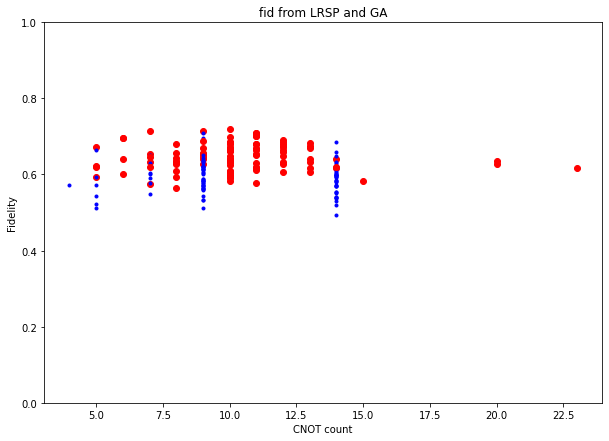

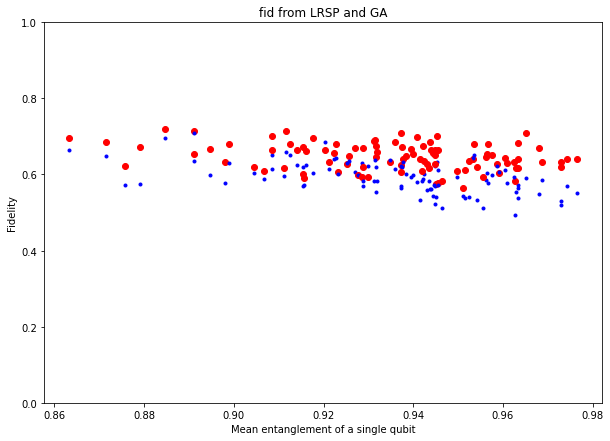

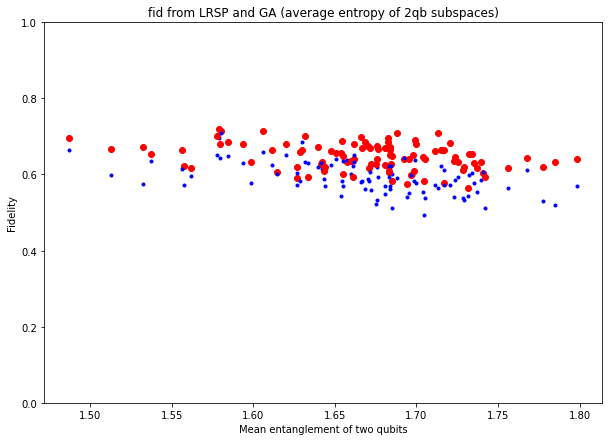

Text(0.5, 0, 'Mean entanglement of a single qubit')

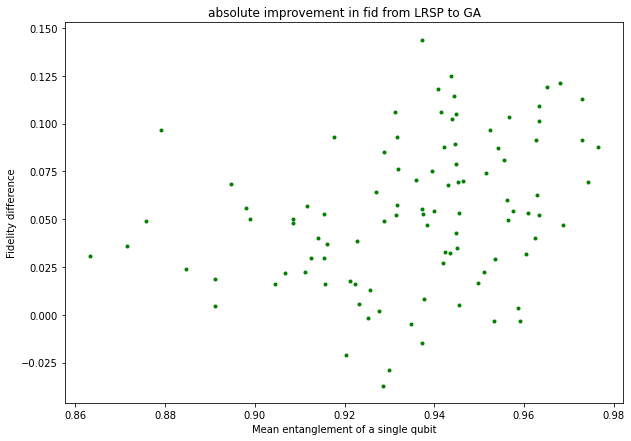

In [40]:
plt.figure(figsize=(10,7))
#plt.ylim(0,1.0)
plt.title('fid from LRSP and GA')

for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    ga_best_cnot = ga_max_fids.cnots[ga_max_fids.noisy_fids.eq(ga_max_fids.noisy_fids.max())].max()
    lrsp_best_cnot = lrsp_max_fids.cnots[lrsp_max_fids.noisy_fids.eq(lrsp_max_fids.noisy_fids.max())].max()
    plt.scatter(x=ga_best_cnot, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=lrsp_best_cnot, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('CNOT count')
plt.show()

plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']
    plt.scatter(x=avg_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('Mean entanglement of a single qubit')
plt.show()


plt.figure(figsize=(10,7))
plt.title('fid from LRSP and GA (average entropy of 2qb subspaces)')
for name, avg_2qb_ent in states_with_avg_2qb_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    plt.scatter(x=avg_2qb_ent, y=ga_max_fids.noisy_fids.max(), color='red')
    plt.scatter(x=avg_2qb_ent, y=lrsp_max_fids.noisy_fids.max(), color='blue', marker='.')
plt.ylim(0,1)
plt.ylabel('Fidelity')
plt.xlabel('Mean entanglement of two qubits')
plt.show()

plt.figure(figsize=(10,7))
plt.title('absolute improvement in fid from LRSP to GA')
for name, avg_ent in states_with_avg_ent.items():
    data = analysis[name]
    ga_max_fids = data['ga_max_fids']
    lrsp_max_fids = data['lrsp_max_fids']

    plt.scatter(x=avg_ent, y=data['ga_max_fids'].noisy_fids.max() - data['lrsp_max_fids'].noisy_fids.max(), color='green', marker='.')
    
plt.ylabel('Fidelity difference')
plt.xlabel('Mean entanglement of a single qubit')
